# Vertex Buffers

__vertex declaration, vertex bindings, index buffer__

In this example we show how to create vertex buffers, load the data, declare in a pipeline the vertex locations, the vertex bindings (if it is statically set in the pipeline) and how to bind vertex buffers and index buffers in the command manager before drawing.

Similar to previous example:

In [1]:
import vulky as vk
import torch
vk.create_device(debug=True)
SCREEN_WIDTH = 512
SCREEN_HEIGHT = 512
render_target = vk.render_target(
    image_format=vk.Format.VEC4,
    width=SCREEN_WIDTH,
    height=SCREEN_HEIGHT
)
depth_buffer = vk.depth_stencil(
    width=SCREEN_WIDTH,
    height=SCREEN_HEIGHT
)

[INFO] Initial available layers: ['VK_LAYER_NV_optimus', 'VK_LAYER_NV_nomad_release_public_2019_3_0', 'VK_LAYER_OBS_HOOK', 'VK_LAYER_NV_nomad_release_public_2021_5_1', 'VK_LAYER_NV_GPU_Trace_release_public_2021_5_1', 'VK_LAYER_LUNARG_api_dump', 'VK_LAYER_LUNARG_gfxreconstruct', 'VK_LAYER_KHRONOS_synchronization2', 'VK_LAYER_KHRONOS_validation', 'VK_LAYER_LUNARG_monitor', 'VK_LAYER_LUNARG_screenshot', 'VK_LAYER_KHRONOS_profiles', 'VK_LAYER_KHRONOS_shader_object']
[INFO] Vulkan Instance created...
[INFO] Debug instance created...
[INFO] Supported features {'coop_mat': True, 'rt': 1, 'rq': True, 'atomic': 1}
[INFO] Available devices: 1
[INFO] Selected device: NVIDIA GeForce RTX 2080 Ti

[INFO] Selected device index: 0

[INFO] 5 available queue family
[PRINT] Inserted device layer "VK_LAYER_KHRONOS_validation" (C:\VulkanSDK\1.3.275.0\Bin\.\VkLayer_khronos_validation.dll)
[PRINT] Inserted device layer "VK_LAYER_OBS_HOOK" (C:\ProgramData\obs-studio-hook\.\graphics-hook64.dll)
[PRINT] Inserte

In [2]:
vertex_buffer = vk.vertex_buffer(4, element_description=dict(
    P=vk.vec3,
    C=vk.vec2
))

In [3]:
with vertex_buffer.map(mode='in') as vb:
    vb.P = [
        [-.9, -.9, 0.5],
        [.9, -.9, 0.5],
        [.9, .9, 0.5],
        [-.9, .9, 0.5]
    ]
    vb.C = [
        [0.0, 0.0],
        [1.0, 0.0],
        [1.0, 1.0],
        [0.0, 1.0]
    ]

In [4]:
index_buffer = vk.index_buffer(6)
index_buffer.load([0, 1, 2, 0, 2, 3])

tensor([0, 0, 0, 0, 1, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 3, 0, 0, 0],
       device='cuda:0', dtype=torch.uint8)

In [5]:
vertex_shader_code = """
#version 450
#extension GL_EXT_scalar_block_layout: enable

layout(location = 0) in vec3 in_position;
layout(location = 1) in vec2 in_coordinates;
layout(location = 0) out vec2 out_coordinates;

void main()
{
    gl_Position = vec4(in_position, 1.0);
    out_coordinates = in_coordinates;
}
"""
fragment_shader_code = """
#version 450
layout(location = 0) in vec2 in_coordinates;
layout(location = 0) out vec4 out_color;
void main() {
    out_color = vec4(in_coordinates.x, in_coordinates.y, 1.0, 1.0);
}
"""

In [6]:
pipeline = vk.pipeline_graphics()
pipeline.attach(slot=0, render_target=vk.Format.VEC4)
pipeline.attach(slot=1, depth_buffer=vk.Format.DEPTH_STENCIL)

In [7]:
pipeline.vertex(location=0, in_position=vk.Format.VEC3)
pipeline.vertex(location=1, in_coordinates=vk.Format.VEC2)
pipeline.vertex_binding(
    binding=0,
    stride=(3+2)*4,
    in_position=0,
    in_coordinates=3*4,
)

In [8]:
with pipeline.shader_stages(vk.ShaderStage.VERTEX):
    pipeline.load_shader_from_source(vertex_shader_code)
with pipeline.shader_stages(vk.ShaderStage.FRAGMENT):
    pipeline.load_shader_from_source(fragment_shader_code)
pipeline.close()  # This creates the internal pipeline object and bindings

[INFO] Compiled code for vert
[INFO] Compiled code for frag


In [9]:
framebuffer = pipeline.create_framebuffer(
    width=SCREEN_WIDTH,
    height=SCREEN_HEIGHT,
    render_target=render_target,
    depth_buffer=depth_buffer
)

In [10]:
man = vk.graphics_manager()
man.clear_color(render_target, (0.0, 0.0, 0.5, 1.0))
man.clear_depth_stencil(depth_buffer, 1.0, 0)
man.set_pipeline(pipeline)
man.set_framebuffer(framebuffer)

In [11]:
man.bind_vertex_buffer(0, vertex_buffer)
man.bind_index_buffer(index_buffer)
man.dispatch_indexed_primitives(6)
man.freeze()

vk.submit(man)

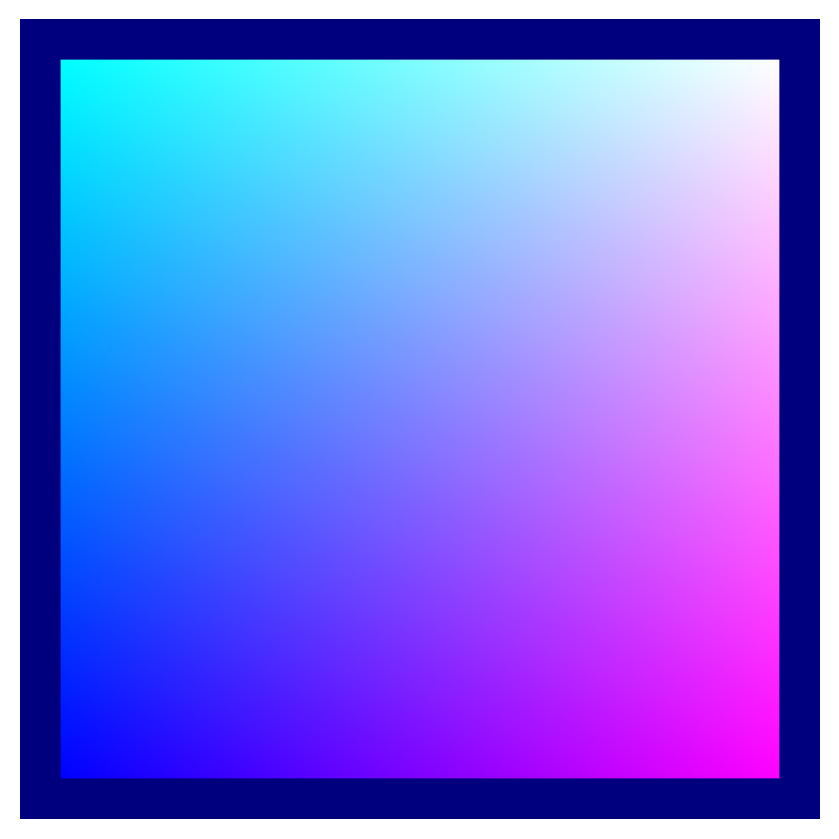

In [12]:
staging = vk.tensor(render_target.height, render_target.width, 4)
render_target.save(staging)
import matplotlib.pyplot as plt
# visualize the tensor with matplotlib
plt.figure(figsize=(4,4), dpi=200)
plt.imshow(staging.cpu())
plt.gca().axis('off')
plt.tight_layout(pad=0.0)
plt.savefig('teaser4.jpg')
plt.show()